In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set a random seed for reproducibility
np.random.seed(42)

In [2]:
# process and standardize data
# This is not an all inclusive function....you should improve!
def preprocess_data(df):

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # correct column names
    new_column_names = ['sepal_l', 'sepal_w', 'petal_l', 'petal_w', 'class']
    df.columns = new_column_names

    # Handle missing values 

    # Encode categorical features
    # Initialize LabelEncoder
    le = LabelEncoder()
    
    # Apply label encoding to a column
    df['class'] = le.fit_transform(df['class'])
    
    print("\nMapping for 'class':")
    for i, label in enumerate(le.classes_):
        print(f"{label}: {i}")

    # change data types

    # Separate features and target
    X = df.drop(columns=['class'], axis=1)
    y = df[['class']]

    # Standardize numerical features
    numeric_cols = ['sepal_l','sepal_w','petal_l','petal_w']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


    print(f"\n********************* \nFirst 5 Rows of X after transformation: \n{X.head()}\n*********************")
    print(f"First 5 Rows of y after transformation: \n{y.head()}\n********************* \n")
    
    return X, y

In [3]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
# ### Reading-in the Iris data

file_path = 'iris.data'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
    print(f"\n********************* \nDataset Shape: {df.shape} \n********************* \nDataset Columns: \n{df.columns}\n********************* \nData Description: \n{df.describe()} \n********************* \nDoes Data Contain Null Values \n{df.isnull().all()}")
    print(f"\n********************* \n Counts of Response Variables: \n {df.iloc[:,4].value_counts()}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'iris.data'. First 5 rows:
     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa

********************* 
Dataset Shape: (150, 5) 
********************* 
Dataset Columns: 
Index([0, 1, 2, 3, 4], dtype='int64')
********************* 
Data Description: 
                0           1           2           3
count  150.000000  150.000000  150.000000  150.000000
mean     5.843333    3.054000    3.758667    1.198667
std      0.828066    0.433594    1.764420    0.763161
min      4.300000    2.000000    1.000000    0.100000
25%      5.100000    2.800000    1.600000    0.300000
50%      5.800000    3.000000    4.350000    1.300000
75%      6.400000    3.300000    5.100000    1.800000
max      7.900000    4.400000    6.900000    2.500000 
********************* 
Does Data Contain Null Values 
0    False
1    False
2    False

In [6]:
# preprocess data with created function
X, y = preprocess_data(df)

First 5 Rows of Data before transformation: 
     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa
********************* 


Mapping for 'class':
Iris-setosa: 0
Iris-versicolor: 1
Iris-virginica: 2

********************* 
First 5 Rows of X after transformation: 
    sepal_l   sepal_w   petal_l   petal_w
0 -0.900681  1.032057 -1.341272 -1.312977
1 -1.143017 -0.124958 -1.341272 -1.312977
2 -1.385353  0.337848 -1.398138 -1.312977
3 -1.506521  0.106445 -1.284407 -1.312977
4 -1.021849  1.263460 -1.341272 -1.312977
*********************
First 5 Rows of y after transformation: 
   class
0      0
1      0
2      0
3      0
4      0
********************* 



In [7]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# Uses scikit-learn's recommenation for classification that combines nearest neighbors classifier with NCA (NeighborhoodComponentAnalysis)
# This method naturally handle's multi-class problems without any increase in model size, and does not introduce additional parameters that require fine-tuning

# NCA is a metric learning technique that aims to find a linear transformation of the input features that maximizes the expected leave-one-out classification accuracy of a stochastic nearest neighbor rule
# NCA n_components is the preferred dimesionality of the projected space. If none, it is set to n_features (i.e., 4 in IRIS dataset)
n_features = 4
nca = NeighborhoodComponentsAnalysis(n_components = n_features, random_state = 42)

# KNN n_neighbors is number of neighbors to use; p =1 manhattan_distance, p=2 euclidean_distance; metric is distance metric with minikowski being eclidean when p=2
k = 3
knn = KNeighborsClassifier(n_neighbors = k, p = 2, metric = 'minkowski')

# creates a pipeline to chain together multiple processing steps and a final estimator to streamline ML workflow
# The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. 
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])

# fit the NCA + KNN model
nca_pipe.fit(X_train, y_train.values.ravel())

# Evaluating the performance of NCA often involves assessing how well a KNN classifier performs on the data after it has been transformed by the learned NCA embedding
# Uses Pipeline's score() method to provide the NCA score of the test data
# This is the classification accuracy of a KNN classifier in transformed space learned by NCA.
print(nca_pipe.score(X_test, y_test.values.ravel()))

0.9473684210526315


In [9]:
# tune k and n_features
nca__n_components = [1, 2, 3, 4]
knn__n_neighbors = [3, 4, 5, 6, 7, 8, 9, 10] 

for i, n in enumerate(nca__n_components):
    for j, k in enumerate(knn__n_neighbors):
        nca_t = NeighborhoodComponentsAnalysis(n_components = n, random_state = 42)
        knn_t = KNeighborsClassifier(n_neighbors = k, p = 2, metric = 'minkowski')
        nca_pipe_t = Pipeline([('nca', nca_t), ('knn', knn_t)])
        nca_pipe_t.fit(X_train, y_train.values.ravel())
        print(f"n = {n} k = {k} NCA Score = {nca_pipe_t.score(X_test, y_test.values.ravel())}")

n = 1 k = 3 NCA Score = 1.0
n = 1 k = 4 NCA Score = 1.0
n = 1 k = 5 NCA Score = 1.0
n = 1 k = 6 NCA Score = 1.0
n = 1 k = 7 NCA Score = 1.0
n = 1 k = 8 NCA Score = 1.0
n = 1 k = 9 NCA Score = 0.9736842105263158
n = 1 k = 10 NCA Score = 0.9736842105263158
n = 2 k = 3 NCA Score = 0.9736842105263158
n = 2 k = 4 NCA Score = 0.9473684210526315
n = 2 k = 5 NCA Score = 0.9736842105263158
n = 2 k = 6 NCA Score = 0.9736842105263158
n = 2 k = 7 NCA Score = 0.9473684210526315
n = 2 k = 8 NCA Score = 0.9736842105263158
n = 2 k = 9 NCA Score = 0.9473684210526315
n = 2 k = 10 NCA Score = 0.9473684210526315
n = 3 k = 3 NCA Score = 1.0
n = 3 k = 4 NCA Score = 0.9736842105263158
n = 3 k = 5 NCA Score = 1.0
n = 3 k = 6 NCA Score = 1.0
n = 3 k = 7 NCA Score = 1.0
n = 3 k = 8 NCA Score = 1.0
n = 3 k = 9 NCA Score = 1.0
n = 3 k = 10 NCA Score = 1.0
n = 4 k = 3 NCA Score = 0.9473684210526315
n = 4 k = 4 NCA Score = 0.9473684210526315
n = 4 k = 5 NCA Score = 0.9473684210526315
n = 4 k = 6 NCA Score = 0.92105

In [10]:
# Define the hyperparameter grid for tuning
# We will search for the best number of neighbors for KNN and the best number of components for NCA.
param_grid = {
    'nca__n_components': [1, 2, 3, 4], 
    'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10] 
}

# Create and fit the GridSearchCV object
# This will perform an exhaustive search over the parameter grid
# using 5-fold cross-validation.
print("Performing hyperparameter tuning with GridSearchCV...")
grid_search = GridSearchCV(nca_pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train.values.ravel())

Performing hyperparameter tuning with GridSearchCV...


,estimator,Pipeline(step...eighbors=3))])
,param_grid,"{'knn__n_neighbors': [3, 4, ...], 'nca__n_components': [1, 2, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,2


In [11]:
# Get the best estimator and make predictions
print("\nHyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")

# Use the best model found by the grid search for predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and print the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Data: {accuracy:.4f}")


Hyperparameter tuning complete.
Best parameters found: {'knn__n_neighbors': 5, 'nca__n_components': 2}

Model Accuracy on Test Data: 0.9737


### In-Class Question 1 (type 1. YOUR RESPONE in response box on blackbaord)
**Why did we use the values found by GridSearchCV instead of our manual hyperparameter tunning? Do research and provide a logical explaination.**

We use GridSearchCV instead of our manual hyperparameter tunning, because it systematically searches through all possible combinations of specified parameters using cross-validation. With this approach we find the optimal values that generalize best to unseen data, reducing the possibilites of overfitting to the training set. Manual tuning relies on intuition or trial-and-error. GridSearchCV is more objective, thorough and statistically sound for hyperparameter selection, which in the end would lead to a more reliable model performance. 


--- Confusion Matrix ---
[[15  0  0]
 [ 0 11  0]
 [ 0  1 11]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



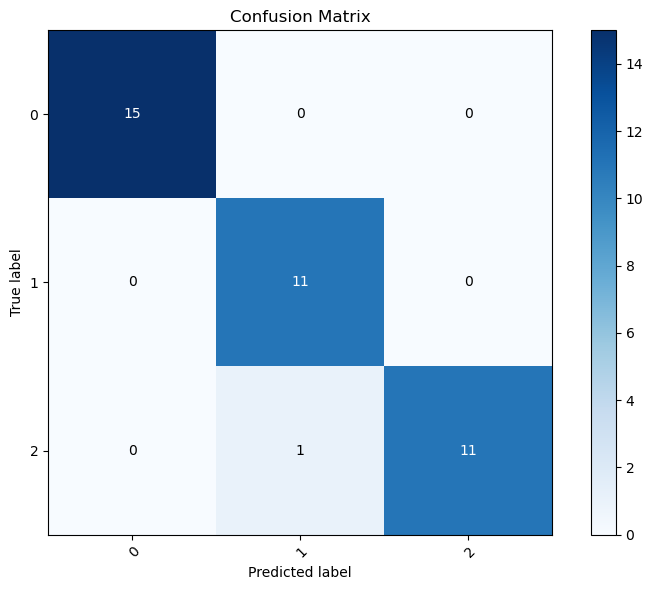

In [13]:
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)